# Import

In [68]:
import os
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
torch.manual_seed(0)

# Load Data

In [8]:
def load_image_dataset(dataset_dir, shuffle=False):

    dataset_dir = Path(dataset_dir)

    images_paths = []
    labels = []

    # iterate through each image folder
    for c in os.listdir(dataset_dir):
        c_dir = dataset_dir / c
        # if not a folder, continue
        if os.path.isfile(c_dir):
            continue
        # list all images inside image folder
        images = os.listdir(c_dir)
        # append to list
        for image in images:
            # if in image format, append to list
            image_formats = ["jpg", "jpeg", "png"]
            if any(image.endswith(ext) for ext in image_formats):
                image_path = c_dir / image
                images_paths.append(image_path)
                labels.append(c)

    # shuffle dataset
    if shuffle:
        import random

        random.seed(0)
        indices = list(zip(images_paths, labels))
        random.shuffle(indices)
        images_paths, labels = zip(*indices)

    return images_paths, labels

In [16]:
x_train, y_train = load_image_dataset("dataset/cat-dog/train", shuffle=True)
x_test, y_test = load_image_dataset("dataset/cat-dog/test", shuffle=True)

In [17]:
x_train[:5], y_train[:5]

((PosixPath('dataset/cat-dog/train/dogs/dog_103.jpg'),
  PosixPath('dataset/cat-dog/train/cats/cat_557.jpg'),
  PosixPath('dataset/cat-dog/train/dogs/dog_269.jpg'),
  PosixPath('dataset/cat-dog/train/dogs/dog_178.jpg'),
  PosixPath('dataset/cat-dog/train/dogs/dog_290.jpg')),
 ('dogs', 'cats', 'dogs', 'dogs', 'dogs'))

In [18]:
x_test[:5], y_test[:5]

((PosixPath('dataset/cat-dog/test/cats/cat_244.jpg'),
  PosixPath('dataset/cat-dog/test/cats/cat_538.jpg'),
  PosixPath('dataset/cat-dog/test/dogs/dog_369.jpg'),
  PosixPath('dataset/cat-dog/test/dogs/dog_442.jpg'),
  PosixPath('dataset/cat-dog/test/dogs/dog_464.jpg')),
 ('cats', 'cats', 'dogs', 'dogs', 'dogs'))

In [60]:
class ImageDataset(Dataset):
    def __init__(self, x, y, transform=None, target_transform=None) -> None:
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, index: int):
        x = Image.open(self.x[index])
        y = self.y[index]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


def target_transform(x, reverse=False):
    map_ = {
        "cats": 0,
        "dogs": 1,
    }
    if reverse:
        map_ = {int(v): k for k, v in map_.items()}
    return map_.get(x)

train_dataset = ImageDataset(
    x_train, y_train, transform=transform, target_transform=target_transform
)
test_dataset = ImageDataset(
    x_test, y_test, transform=transform, target_transform=target_transform
)

In [48]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [66]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs shape: {inputs.shape}")  # Should be (batch_size, channel, H, W)
    print(f"Inputs range: {inputs.max().item(), inputs.min().item()}")  # Should be (batch_size, channel, H, W)
    print(f"Targets shape: {targets.shape}")  # Should be (batch_size)
    print(f"Targets: {targets}") 

    break

Batch 1
Inputs shape: torch.Size([16, 3, 224, 224])
Inputs range: (1.0000004768371582, -1.0)
Targets shape: torch.Size([16])
Targets: tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


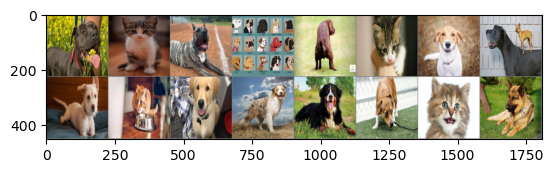

dogs cats dogs dogs dogs cats dogs dogs dogs cats dogs dogs dogs dogs cats dogs


In [63]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(
    " ".join(f"{target_transform(int(labels[j]), reverse=True)}" for j in range(batch_size))
)

# Model

In [82]:
class CNN(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(in_features=34992, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=2)
        
    def forward(self, x):   
        # conv layer
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2), stride=(2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2), stride=(2, 2))
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
samples = torch.zeros(size=(8, 3, 224, 224))
sample_model = CNN()
sample_model(samples).shape

torch.Size([8, 2])

# Training